In [18]:
import torch
import random
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFile, Image

from LAG import LAG
from CelebDataset import CelebDataset
from MyModels import GeneratorModel, DiscriminatorModel
import imageio.v2 as imageio


In [2]:
#GPU Check

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device,"is available!")

cuda:0 is available!


In [3]:
# DATA set check and load

transform = transforms.Compose([
                transforms.Resize(64),
                transforms.CenterCrop(64),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])
dataset = LAG('D:\workspace\DCGAN\PCA_DCGAN\LAG_dataset\dataset', transform=transform)
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, num_workers=0)

torch.Size([64, 3, 64, 64])


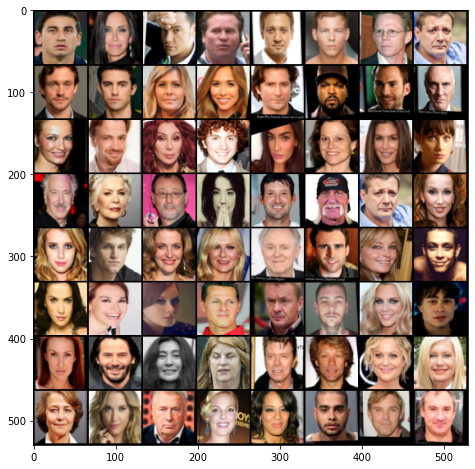

In [4]:
# view function and check the sample imgs

def view_samples(images):
    img = torchvision.utils.make_grid(images, padding=2, normalize=True)
    img = img.cpu().numpy()
    plt.figure(figsize = (8, 8))
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()
    
test = iter(dataloader)
sample = next(test)
print(sample.size())
view_samples(sample)

In [5]:
# save the progress of learning result pics

def save_progress(images, epoch, step):
    img = torchvision.utils.make_grid(images, padding=2, normalize=True)
    img = img.cpu().numpy()
    img = np.transpose(img, (1,2,0))
    img = np.uint8(img*255)
    imageio.imwrite(f"progress_pics/{epoch}-{step}.jpg", img)

In [6]:
# save the model's state

def save_model_state(model, optimizer, loss, epoch, name):
    model_path = f"saved_models/{name}{epoch}.pt"
    state_dict = {
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'opt_state_dict' : optimizer.state_dict(),
        'training_loss' : loss,
    }
    torch.save(state_dict, model_path)

In [7]:
# load the saved model

def load_model_state(model, filename):
    model_info = torch.load(f"saved_models/{filename}.pt")
    optimizer = torch.optim.Adam(model.parameters())
    optimizer.load_state_dict(model_info["opt_state_dict"])
    model.load_state_dict(model_info["model_state_dict"])
    return model, optimizer

In [ ]:
# making loss graph function

def plot_losses(gen, dis):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(111)
    ax.plot(gen, label="Generator")
    ax.plot(dis, label="Discriminator")
    plt.title("Gen/Dis losses")
    ax.legend()
    plt.show()

In [8]:
# initialize step

n_z = 128 # 잠재공간 벡터 크기(생성자 입력값 크기)
n_c = 3 # 이미지 채널 갯수(RGB)
n_feature_maps_g = 64 # 생성자의 특징 맵 크기
n_feature_maps_d = 64 # 구분자의 특징 맵 크기
epochs = 100

fixed_noise = torch.randn(64, n_z, 1, 1).to(device)
torch.save(fixed_noise, "fixed_noise.pt")

torch.Size([64, 64])
torch.Size([128, 1, 64, 64])
torch.Size([128, 1, 64, 64])


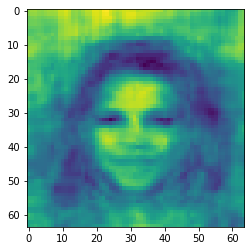

In [19]:
noise = torch.randn(128, 1, 1, 1, device=device)

PCA_path = 'D:\workspace\DCGAN\LSGAN_CelebA\LSGAN_CelebA\progress_pics\PCA_face_result64.jpg'
PCA_img = imageio.imread(PCA_path)

plt.imshow(PCA_img)


x_PCA_img = torch.tensor(PCA_img).to(device)
print(x_PCA_img.shape)
image = x_PCA_img.repeat(128,1,1,1).float()
print(image.shape)

test = noise * image
print(test.size())

In [14]:
g_losses = [] # 생성자 loss
d_losses = [] # 구분자 loss

Dis = DiscriminatorModel(n_c, n_feature_maps_d).to(device) # 구분자 모델 생성
Gen = GeneratorModel(n_z, n_feature_maps_g, n_c).to(device) # 생성자 모델 생성

lr_g = 2e-4 # 생성자 learning rate 설정
lr_d = 2e-4 # 구분자 learning rate 설정
Dis_opt = optim.Adam(Dis.parameters(), lr=lr_d, betas=(0.5, 0.999)) # 구분자 옵티마이저 설정
Gen_opt = optim.Adam(Gen.parameters(), lr=lr_g, betas=(0.5, 0.999)) # 생성자 옵티마이저 설정
criterion = nn.MSELoss()

len(dataloader)
checkpoint = int(len(dataloader)/20)

d_running_loss = 0.
g_running_loss = 0.


In [15]:
print(Dis)

DiscriminatorModel(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
  (linear): Linear

In [16]:
print(Gen)

GeneratorModel(
  (net): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2,

In [ ]:
# Training part

for e in range(1, epochs+1):
    print(f"Epoch {e} started.")
    for i, batch in enumerate(dataloader, 1):
        
        batch_size = batch.size(0)
        real_image = batch.to(device)

        fake_label = torch.zeros(batch_size, 1, 1, 1).to(device)
        real_label = torch.ones(batch_size, 1, 1, 1).to(device)

        Dis.zero_grad()
        D_x = Dis(real_image)
        D_x_loss = criterion(D_x, real_label)
        d_running_loss += D_x_loss.item()
        D_x_loss.backward()
        
        z = torch.randn(batch_size, n_z, 1, 1).to(device)  
        G_z = Gen(z)
        D_G_z = Dis(G_z.detach())
        D_G_z_loss = criterion(D_G_z, fake_label)
        d_running_loss += D_G_z_loss.item()
        D_G_z_loss.backward()
        
        Dis_opt.step()
        
        Gen.zero_grad()
        G_z = Gen(z)
        D_G_z = Dis(G_z)
        G_z_loss = criterion(D_G_z, real_label)
        g_running_loss += G_z_loss.item()
        
        G_z_loss.backward()    
        Gen_opt.step()
        
        if i % checkpoint == 0:
            
            g_current_loss = g_running_loss/checkpoint
            d_current_loss = d_running_loss/checkpoint
            g_losses.append(g_current_loss)
            d_losses.append(d_current_loss)
            print(f"[Generator loss: {g_current_loss}, Discriminator loss: {d_current_loss}]")
            fixed_z_images = Gen(fixed_noise).detach()
            save_progress(fixed_z_images, e, i//checkpoint)
            g_running_loss = 0.
            d_running_loss = 0.